# Homework 4 - Hard Coding

## Exercise 1 - Implement your own Shazam


In this notebook we are going to implement our Shazam by using the MinHashing method to find a match between our query and the dataset. The dataset we used was downloaded from [Kaggle](https://www.kaggle.com/dhrumil140396/mp3s32k)


#### Import Libraries

In [245]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import random
import json
import pandas as pd
import os
from pathlib import Path  
from tqdm.notebook import tqdm

### Utility Functions

First let's define some useful functions that we need for working with audio files. First we convert all *mp3* files in *wav* files so that we can extract some informations using the **Librosa** library.

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
        
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    

### Settings

Here we can adjust the settings of our search engine:

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 

#### File Path

In this step we read our dataset and our queries, and store the informations in *audio_info* and *query_info* respectively

In [9]:
data_folder = Path("./mp3s-32k/")
import glob, os
#os.chdir("mp3s-32k/")
mp3_tracks = ["./mp3s-32k/"+file for file in glob.glob("*/*/*.mp3")]
#date pre-processing mp3 to wav format
os.chdir("../")
tracks = [convert_mp3_to_wav(str(track)) for track in mp3_tracks]
os.chdir("query/")
query_folder = Path("query/")
queries = ["query/" + file for file in glob.glob("*.wav")]
os.chdir("../")

In [10]:
print(mp3_tracks[:10])

['./mp3s-32k/metallica/Metallica/04-The_Unforgiven.mp3', './mp3s-32k/metallica/Metallica/05-Wherever_I_May_Roam.mp3', './mp3s-32k/metallica/Metallica/12-The_Struggle_Within.mp3', './mp3s-32k/metallica/Metallica/01-Enter_Sandman.mp3', './mp3s-32k/metallica/Metallica/07-Through_the_Never.mp3', './mp3s-32k/metallica/Metallica/03-Holier_than_Thou.mp3', './mp3s-32k/metallica/Metallica/10-The_God_that_Failed.mp3', './mp3s-32k/metallica/Metallica/06-Dont_Tread_on_Me.mp3', './mp3s-32k/metallica/Metallica/09-Of_Wolf_and_Man.mp3', './mp3s-32k/metallica/Metallica/08-Nothing_Else_Matters.mp3']


In [11]:
audio_info = list(enumerate(tracks))
print(len(audio_info))
print(audio_info[:10])

1413
[(0, './mp3s-32k/metallica/Metallica/04-The_Unforgiven.wav'), (1, './mp3s-32k/metallica/Metallica/05-Wherever_I_May_Roam.wav'), (2, './mp3s-32k/metallica/Metallica/12-The_Struggle_Within.wav'), (3, './mp3s-32k/metallica/Metallica/01-Enter_Sandman.wav'), (4, './mp3s-32k/metallica/Metallica/07-Through_the_Never.wav'), (5, './mp3s-32k/metallica/Metallica/03-Holier_than_Thou.wav'), (6, './mp3s-32k/metallica/Metallica/10-The_God_that_Failed.wav'), (7, './mp3s-32k/metallica/Metallica/06-Dont_Tread_on_Me.wav'), (8, './mp3s-32k/metallica/Metallica/09-Of_Wolf_and_Man.wav'), (9, './mp3s-32k/metallica/Metallica/08-Nothing_Else_Matters.wav')]


We can see that our dataset have 1413 different songs which are stored in this way:

In [12]:
query_info = list(enumerate(queries))
len(query_info)

10

We also have 10 queries that we have to detect and are stored in this way:

In [13]:
query_info

[(0, 'query/track8.wav'),
 (1, 'query/track9.wav'),
 (2, 'query/track10.wav'),
 (3, 'query/track2.wav'),
 (4, 'query/track3.wav'),
 (5, 'query/track1.wav'),
 (6, 'query/track4.wav'),
 (7, 'query/track5.wav'),
 (8, 'query/track7.wav'),
 (9, 'query/track6.wav')]

### Audio Signals
This is an example of what our custom functions do. In particular we are going to work with *audio peaks*.

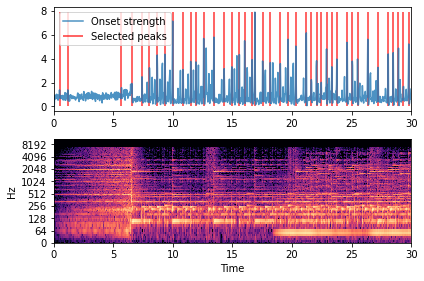

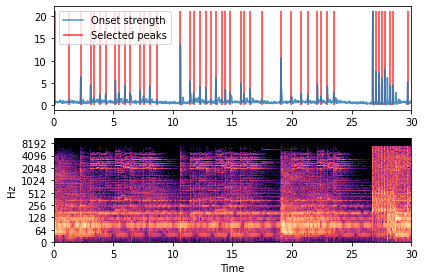

In [17]:
for idx, audio in audio_info:
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    plot_spectrogram_and_peaks(track, sr, peaks, onset_env)
        
        

### Hashing

Let's implement our Hash function. As stated before we are going to work with *audio peaks*.
As our Hash Function we are going to consider:
\begin{equation}
    h(x) = ax + b (mod P)
\end{equation}

where **a** and **b** are random integers, the first one chosen between 1 and M, the second one chosen between 0 and M where:
\begin{equation}M=2^{32} - 1 \end{equation}
and P is a **prime number** bigger than M.
We are going to generate n=10 hash functions and for each one of them we are going to evaluate it for every element of the array **peaks** and taking the minimum of all the values obtained. Doing so, we'll end up with a **signature array** of length n for every song in the dataset and in the query.

Let's start by defining some functions.

The first one randomizes our coefficients a and b and stores them in two separate vectors of length n:

In [18]:
def getCoefficient(number_of_hash, upperBound):
    '''I use this function to randomize the coefficients of the Hash Function'''
    
    a=[]
    b=[]
    for _ in range(number_of_hash):
        tmp = random.randint(1,upperBound)
        a.append(tmp)
        tmp = random.randint(0,upperBound)
        b.append(tmp)
    return a,b    

Here we define the basic Hash Function:

In [19]:
def HashFunction(x,a,b,C):   
    return (a*x + b) % C    

Lastly we have to find the smallest prime bigger than our M.

In [20]:
def isPrime(n):
    for k in range(2, int(np.sqrt(n))+1,1):
        if n%k==0:
            return False
    return True

foundPrime = False
n = 2**32 - 1
while not foundPrime:
    if isPrime(n):
        print(n)
        foundPrime = True
    n+=1

4294967311


### Parameters
Here we define the parameters:

In [21]:
M = 2**32 - 1  #our Upper Bound
n_hash = 10
C = 4294967311   #prime number > M
a,b = getCoefficient(n_hash,M) 

### First we decided to try classic approach (without MinHash) to create signatures and then compute similiarity by counting Jaccard score for each par. Later, we will do the same in more efficient way using MinHash and will compare results of two approaches

## Classic approach

### Create dictionaries

Let's now read our dataset sequentially and create two JSON dictionaryies, one for the database and the other for the queries, which will store all the signatures gathered from the songs and for the queries and saving the indices:

#### For the Song List

In [32]:
#time control
import time
start = time.time()

In [33]:
signatures = {}

for idx,song in tqdm(audio_info):
    _,_,_,peaks = load_audio_peaks(song, OFFSET, DURATION, HOP_SIZE)
    signature = []
    for i in range(n_hash):
        hashvalues = []
        for peak in peaks:
            tmp_hash = HashFunction(peak, a[i], b[i], C)
            hashvalues.append(tmp_hash)
        signature.append(int(min(hashvalues)))
    signatures[idx] = signature

  0%|          | 0/1413 [00:00<?, ?it/s]

We'll save this dictionary in *data/Signatures.json*

In [34]:
with open('data/Signatures.json', 'w', encoding="utf-8") as f:
                json.dump(signatures, f)

#### For the Query List

In [35]:
queries = {}

for idx,song in tqdm(query_info):
    _,_,_,peaks = load_audio_peaks(song, OFFSET, DURATION, HOP_SIZE)
    signature = []
    for i in range(n_hash):
        hashvalues = []
        for peak in peaks:
            tmp_hash = HashFunction(peak, a[i], b[i], C)
            hashvalues.append(tmp_hash)
        signature.append(int(min(hashvalues)))
    queries[idx] = signature

  0%|          | 0/10 [00:00<?, ?it/s]

We'll save this dictionary in *data/querySignatures.json*

In [36]:
with open('data/querySignatures.json', 'w', encoding="utf-8") as f:
                json.dump(queries, f)

### Matching the queries

To find the most similar signatures we are going to use the **Jaccard Similarity**, a similarity measure between two sets defined as:
\begin{equation}
J(A,B) = \frac{|A \cap B|}{|A \cup B|}
\end{equation}

In [37]:
def jaccardSimilarity(setA,setB):
    intersection = setA.intersection(setB)
    union = setA.union(setB)
    return len(intersection)/len(union)

Now let's read in our query dictionary and for each entry let's find the most similar signatures in the *Signatures.json* file.

In [226]:
file = open('data/querySignatures.json','r')
query_data = json.load(file)
file = open('data/Signatures.json','r')
data = json.load(file)
file = open('./mp3s-32k/all.list')
song_list = file.readlines()

def findMatch(threshold):
    for query_idx in query_data:
        querySet = set(query_data[query_idx])
        similarity = []
        for idx in data:
            signatureSet = set(data[idx])
            score = jaccardSimilarity(querySet, signatureSet)
            similarity.append(score)
            if score >= threshold:
                print(f"The query '{query_info[int(query_idx)][1]}' was matched with the song:")
                print(f"{song_list[int(idx)].split('/')[2][3:-1]} by {song_list[int(idx)].split('/')[0]}")
                print(f"Similarity Score: {score}")
        

In [39]:
findMatch(threshold = 1)

The query 'query/track8.wav' was matched with the song:
It_Will_Take_A_Long_Long_Time by roxette
Similarity Score: 1.0
The query 'query/track9.wav' was matched with the song:
Room_Off_The_Street by suzanne_vega
Similarity Score: 1.0
The query 'query/track10.wav' was matched with the song:
The_Snakepit by cure
Similarity Score: 1.0
The query 'query/track2.wav' was matched with the song:
4th_of_July by u2
Similarity Score: 1.0
The query 'query/track3.wav' was matched with the song:
Motorbreath by metallica
Similarity Score: 1.0
The query 'query/track1.wav' was matched with the song:
The_Night_Will_Only_Know by garth_brooks
Similarity Score: 1.0
The query 'query/track4.wav' was matched with the song:
Everyday by dave_matthews_band
Similarity Score: 1.0
The query 'query/track5.wav' was matched with the song:
Save_Me by queen
Similarity Score: 1.0
The query 'query/track7.wav' was matched with the song:
Mystified by fleetwood_mac
Similarity Score: 1.0
The query 'query/track6.wav' was matched

In [40]:
findMatch(threshold = 0.2)

The query 'query/track8.wav' was matched with the song:
It_Will_Take_A_Long_Long_Time by roxette
Similarity Score: 1.0
The query 'query/track8.wav' was matched with the song:
Honeymoon_Suite by suzanne_vega
Similarity Score: 0.25
The query 'query/track9.wav' was matched with the song:
Room_Off_The_Street by suzanne_vega
Similarity Score: 1.0
The query 'query/track10.wav' was matched with the song:
The_Snakepit by cure
Similarity Score: 1.0
The query 'query/track2.wav' was matched with the song:
4th_of_July by u2
Similarity Score: 1.0
The query 'query/track3.wav' was matched with the song:
Motorbreath by metallica
Similarity Score: 1.0
The query 'query/track1.wav' was matched with the song:
See_You by depeche_mode
Similarity Score: 0.25
The query 'query/track1.wav' was matched with the song:
Blue_Letter by fleetwood_mac
Similarity Score: 0.25
The query 'query/track1.wav' was matched with the song:
The_Night_Will_Only_Know by garth_brooks
Similarity Score: 1.0
The query 'query/track4.wav

In [42]:
finish = time.time()
time_classic = finish - start
print("Time for finding similiar song with classic algorithm is ", time_classic,"seconds")

Time for finding similiar song with classic algorithm is  684.1491701602936 seconds


## MinHash approach

In [52]:
# Let's construct characteristic matrix
def characteristic_dict(audio_info, song, OFFSET, DURATION, HOP_SIZE):
    """
    input: audio_info, song, OFFSET, DURATION, HOP_SIZE
    output: characteristic dict of audios peaks, char{i} = {c | i in c-th song array of picks}
    """
    char = {}
    for idx,song in tqdm(audio_info):
        _,_,_,peaks = load_audio_peaks(song, OFFSET, DURATION, HOP_SIZE)
        for peak in peaks:
            if peak in char.keys():
                char[peak].append(idx)
            else:
                char[peak] = [idx]
    return char

In [296]:
C = 1299 #number of peak values
a,b = getCoefficient(n_hash, C) 
def signature_matrix(n_hash, audio, OFFSET, DURATION, HOP_SIZE, a, b, C):
    '''
    input: 
      n_hash - number of hash functions
      OFFSET, DURATION, HOP_SIZE - parameters for loadinf picks from audio
      audio - (string, int, pathlib.Path or file-like object): [description] of audio
    output:
       sig - np.array n_hash x len(audio), signature matrix for peaks of input audios
    '''
    sig = np.full([n_hash, len(audio)], np.inf)
    hash_ind = {} #dict with values of hashed functions on peak values
    for idx,song in tqdm(audio):
        _,_,_,peaks = load_audio_peaks(song, OFFSET, DURATION, HOP_SIZE)
        for peak in peaks:
            if peak not in hash_ind.keys():
                hash_ind[peak] = [None]*n_hash
                for i in range(n_hash):
                    hash_ind[peak][i] = HashFunction(peak, a[i], b[i], C)
                    sig[i][idx] = min(sig[i][idx], hash_ind[peak][i])
            else:
                for i in range(n_hash):
                    sig[i][idx] = min(sig[i][idx], hash_ind[peak][i])
    return sig

def similiarity(sig_audio, sig_query):
    '''
    input:
       sig_audio, sig_query - 
               signature matrix for audios between which we wanna find similiarity
    output:
       simil - np.array sig_query.shape[1] x sig_audio.shape[1], simil[i][j] - 
                       similiaraty between rows of query and audio
    '''
    similiarity = np.zeros((sig_query.shape[1], sig_audio.shape[1]))
    for i in range(sig_query.shape[1]):
        similiarity[i] = [np.mean(sig_audio[:, j] == sig_query[:, i]) for j in range (sig_audio.shape[1])]
    return similiarity


def findMatchMinHash(similiarity_matrix, audio_info, query_info, threshold):
    for query_idx in range(similiarity_matrix.shape[0]):
        pd = {}
        for idx in range(similiarity_matrix.shape[1]):
            if similiarity_matrix[query_idx][idx] >= threshold:
                print(f"The query '{query_info[int(query_idx)][1]}' was matched with the song:")
                print(f"{song_list[int(idx)].split('/')[2][3:-1]} by {song_list[int(idx)].split('/')[0]}".replace("_"," "))
                print(f"Similarity Score: {similiarity_matrix[query_idx][idx]}")
        

In [200]:
sign_matrix = signature_matrix(n_hash, audio_info, OFFSET, DURATION, HOP_SIZE,a,b, C)

  0%|          | 0/1413 [00:00<?, ?it/s]

In [201]:
sig_query = signature_matrix(n_hash, query_info, OFFSET, DURATION, HOP_SIZE, a, b, C)

  0%|          | 0/10 [00:00<?, ?it/s]

In [210]:
similiarity_matrix = similiarity(sign_matrix,sig_query)

In [298]:
findMatchMinHash(similiarity_matrix, audio_info, query_info, threshold = 1)

The query 'query/track8.wav' was matched with the song:
It Will Take A Long Long Time by roxette
Similarity Score: 1.0
The query 'query/track9.wav' was matched with the song:
Room Off The Street by suzanne vega
Similarity Score: 1.0
The query 'query/track10.wav' was matched with the song:
The Snakepit by cure
Similarity Score: 1.0
The query 'query/track2.wav' was matched with the song:
4th of July by u2
Similarity Score: 1.0
The query 'query/track3.wav' was matched with the song:
Motorbreath by metallica
Similarity Score: 1.0
The query 'query/track1.wav' was matched with the song:
The Night Will Only Know by garth brooks
Similarity Score: 1.0
The query 'query/track4.wav' was matched with the song:
Everyday by dave matthews band
Similarity Score: 1.0
The query 'query/track5.wav' was matched with the song:
Save Me by queen
Similarity Score: 1.0
The query 'query/track7.wav' was matched with the song:
Mystified by fleetwood mac
Similarity Score: 1.0
The query 'query/track6.wav' was matched

In [297]:
findMatchMinHash(similiarity_matrix, audio_info, query_info, threshold = 0.3)

The query 'query/track8.wav' was matched with the song:
The Perfect Girl by cure
Similarity Score: 0.3
The query 'query/track8.wav' was matched with the song:
Give Me It by cure
Similarity Score: 0.3
The query 'query/track8.wav' was matched with the song:
If I Had It All by dave matthews band
Similarity Score: 0.3
The query 'query/track8.wav' was matched with the song:
The Sun The Rainfall by depeche mode
Similarity Score: 0.3
The query 'query/track8.wav' was matched with the song:
It s Late by queen
Similarity Score: 0.4
The query 'query/track8.wav' was matched with the song:
It Will Take A Long Long Time by roxette
Similarity Score: 1.0
The query 'query/track8.wav' was matched with the song:
One by u2
Similarity Score: 0.3
The query 'query/track9.wav' was matched with the song:
Penthouse Pauper by creedence clearwater revival
Similarity Score: 0.3
The query 'query/track9.wav' was matched with the song:
Basket Case by green day
Similarity Score: 0.3
The query 'query/track9.wav' was ma

As we see all items in query has match with similiar score of 1, so we don't need to use thresho;d less than 1.

### Let's compare results with Jacobian score and MinHash approach

In [304]:
def compareMatch(similiarity_matrix, audio_info, query_info, threshold, query_data, data):
    match_mh = []
    match_jac = []
    query_name = []
    for query_idx in range(similiarity_matrix.shape[0]):
        querySet = set(query_data[str(query_idx)])
        for idx in range(similiarity_matrix.shape[1]):
            
            signatureSet = set(data[str(idx)])
            score = jaccardSimilarity(querySet, signatureSet)
            if score >= threshold:
                query_name.append(query_info[int(query_idx)][1])
                match_jac.append(f"{song_list[int(idx)].split('/')[2][3:-1]} by {song_list[int(idx)].split('/')[0]}, {score}".replace("_"," "))
            if similiarity_matrix[query_idx][idx] >= threshold:
                match_mh.append(f"{song_list[int(idx)].split('/')[2][3:-1]} by {song_list[int(idx)].split('/')[0]}, {similiarity_matrix[query_idx][idx]}".replace("_"," ")) 
            if len(match_mh) < len(match_jac):
                match_mh.append("No match, but Jacobian approach got one")     
            if len(match_mh) > len(match_jac):
                query_name.append(query_info[int(query_idx)][1])
                match_jac.append("No match, but MinHash approach got one")
    print(len(query_name), len( match_mh), len( match_jac))
    comp = pd.DataFrame({"Query Treck name": query_name, "MinHash matches": match_mh, "Jac score": match_jac})
    return comp

### With threshold = 1:

In [305]:
compareMatch(similiarity_matrix, audio_info, query_info,  1, query_data, data)

10 10 10


,Query Treck name,MinHash matches,Jac score
0,query/track8.wav,"It Will Take A Long Long Time by roxette, 1.0","It Will Take A Long Long Time by roxette, 1.0"
1,query/track9.wav,"Room Off The Street by suzanne vega, 1.0","Room Off The Street by suzanne vega, 1.0"
2,query/track10.wav,"The Snakepit by cure, 1.0","The Snakepit by cure, 1.0"
3,query/track2.wav,"4th of July by u2, 1.0","4th of July by u2, 1.0"
4,query/track3.wav,"Motorbreath by metallica, 1.0","Motorbreath by metallica, 1.0"
5,query/track1.wav,"The Night Will Only Know by garth brooks, 1.0","The Night Will Only Know by garth brooks, 1.0"
6,query/track4.wav,"Everyday by dave matthews band, 1.0","Everyday by dave matthews band, 1.0"
7,query/track5.wav,"Save Me by queen, 1.0","Save Me by queen, 1.0"
8,query/track7.wav,"Mystified by fleetwood mac, 1.0","Mystified by fleetwood mac, 1.0"
9,query/track6.wav,"Blue Jay Way by beatles, 1.0","Blue Jay Way by beatles, 1.0"


### With threshold = 0.2

In [307]:
compareMatch(similiarity_matrix, audio_info, query_info,  0.2, query_data, data)[:30]

852 852 852


,Query Treck name,MinHash matches,Jac score
0,query/track8.wav,"And I Love Her by beatles, 0.2","No match, but MinHash approach got one"
1,query/track8.wav,"The Fool On The Hill by beatles, 0.2","No match, but MinHash approach got one"
2,query/track8.wav,"Here There And Everywhere by beatles, 0.2","No match, but MinHash approach got one"
3,query/track8.wav,"Why Can t I Be You by cure, 0.2","No match, but MinHash approach got one"
4,query/track8.wav,"The Perfect Girl by cure, 0.3","No match, but MinHash approach got one"
5,query/track8.wav,"Give Me It by cure, 0.3","No match, but MinHash approach got one"
6,query/track8.wav,"Wendy Time by cure, 0.2","No match, but MinHash approach got one"
7,query/track8.wav,"If I Had It All by dave matthews band, 0.3","No match, but MinHash approach got one"
8,query/track8.wav,"Pay For What You Get by dave matthews band, 0.2","No match, but MinHash approach got one"
9,query/track8.wav,"The Sun The Rainfall by depeche mode, 0.3","No match, but MinHash approach got one"


#### As we see results for thereshold 1 are the same with classic and MinHash approach. But Minhash are more efficient. If we look not it the best matches (with lower threshold) there are difference between Jacobian scores and its approximation with MinHash approach